In [1]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# 超参数设置
config = {
    "model_name": "resnet",  # 可选 "resnet" 或 "vgg"
    "num_epochs": 15,
    "batch_size": 32,
    "learning_rate": 0.001,
    "test_size": 0.2,
    "sample_ratio": 1.0
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "Aerial_Landscapes/"


In [3]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    input_size = 224
    if model_name == "resnet":
        model = models.resnet18(pretrained=use_pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vgg":
        model = models.vgg16(pretrained=use_pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError("不支持的模型名称，请选择 'resnet' 或 'vgg'")
    return model, input_size


In [4]:
def get_transforms(input_size=224):
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform


In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
def load_and_split_dataset(root_dir, test_size=0.2, sample_ratio=1.0):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    for cls_name in classes:
        cls_path = os.path.join(root_dir, cls_name)
        img_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.jpg')]
        random.seed(42)
        random.shuffle(img_files)
        n_samples = int(len(img_files) * sample_ratio)
        split = int(n_samples * (1 - test_size))
        imgs = img_files[:n_samples]
        train_imgs = imgs[:split]
        test_imgs = imgs[split:]
        train_images.extend([cv2.imread(p) for p in train_imgs])
        train_labels.extend([class_to_idx[cls_name]] * len(train_imgs))
        test_images.extend([cv2.imread(p) for p in test_imgs])
        test_labels.extend([class_to_idx[cls_name]] * len(test_imgs))

    return (train_images, train_labels), (test_images, test_labels), classes


In [7]:
def train_model(model, device, train_loader, test_loader, criterion, optimizer, num_epochs=25, patience=5):
    best_acc = 0.0
    no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Accuracy {train_acc:.4f}")

        if train_acc > best_acc:
            best_acc = train_acc
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered.")
                break
    return model, history


In [8]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  7%|▋         | 1/15 [00:21<05:03, 21.67s/it]

Epoch 1: Train Loss 1.1140, Accuracy 0.6508


 13%|█▎        | 2/15 [00:42<04:38, 21.40s/it]

Epoch 2: Train Loss 0.7487, Accuracy 0.7674


 20%|██        | 3/15 [01:03<04:13, 21.17s/it]

Epoch 3: Train Loss 0.6518, Accuracy 0.7941


 27%|██▋       | 4/15 [01:24<03:51, 21.01s/it]

Epoch 4: Train Loss 0.5694, Accuracy 0.8197


 33%|███▎      | 5/15 [01:45<03:28, 20.86s/it]

Epoch 5: Train Loss 0.5372, Accuracy 0.8297


 40%|████      | 6/15 [02:05<03:06, 20.70s/it]

Epoch 6: Train Loss 0.4999, Accuracy 0.8467


 47%|████▋     | 7/15 [02:25<02:44, 20.58s/it]

Epoch 7: Train Loss 0.4794, Accuracy 0.8483


 53%|█████▎    | 8/15 [02:47<02:25, 20.79s/it]

Epoch 8: Train Loss 0.4415, Accuracy 0.8602


 60%|██████    | 9/15 [03:08<02:06, 21.04s/it]

Epoch 9: Train Loss 0.4152, Accuracy 0.8665


 67%|██████▋   | 10/15 [03:30<01:45, 21.14s/it]

Epoch 10: Train Loss 0.4165, Accuracy 0.8684


 73%|███████▎  | 11/15 [03:51<01:24, 21.23s/it]

Epoch 11: Train Loss 0.4037, Accuracy 0.8723


 80%|████████  | 12/15 [04:12<01:03, 21.28s/it]

Epoch 12: Train Loss 0.4049, Accuracy 0.8709


 87%|████████▋ | 13/15 [04:33<00:42, 21.13s/it]

Epoch 13: Train Loss 0.3706, Accuracy 0.8786


 93%|█████████▎| 14/15 [04:54<00:21, 21.14s/it]

Epoch 14: Train Loss 0.3588, Accuracy 0.8842


100%|██████████| 15/15 [05:15<00:00, 21.06s/it]

Epoch 15: Train Loss 0.3622, Accuracy 0.8855


Evaluation Metrics (Precision, Recall, F1-score):

              precision    recall  f1-score   support

 Agriculture     0.9603    0.9062    0.9325       160
     Airport     0.7011    0.8063    0.7500       160
       Beach     0.9868    0.9375    0.9615       160
        City     0.8848    0.9125    0.8985       160
      Desert     0.9000    0.9563    0.9273       160
      Forest     0.9932    0.9062    0.9477       160
   Grassland     0.8994    0.9500    0.9240       160
     Highway     0.9427    0.9250    0.9338       160
        Lake     0.9125    0.9125    0.9125       160
    Mountain     0.9618    0.7875    0.8660       160
     Parking     0.9870    0.9500    0.9682       160
        Port     0.8983    0.9938    0.9436       160
     Railway     0.7672    0.9062    0.8309       160
 Residential     0.9571    0.9750    0.9659       160
       River     0.9545    0.7875    0.8630       160

    accuracy                         0.9075      2400
   macro avg     0.9138    0.

<Figure size 1200x1000 with 0 Axes>

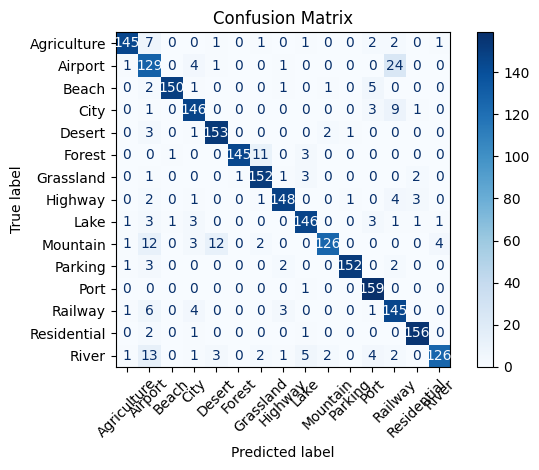

In [9]:
# 加载数据
(train_images, train_labels), (test_images, test_labels), classes = load_and_split_dataset(
    dataset_path,
    test_size=config["test_size"],
    sample_ratio=config["sample_ratio"]
)

# 初始化模型
model, input_size = initialize_model(
    model_name=config["model_name"],
    num_classes=len(classes),
    use_pretrained=True
)
model = model.to(device)

# 数据增强
train_transform, test_transform = get_transforms(input_size)

# 构建Dataset和Loader
train_dataset = CustomDataset(train_images, train_labels, train_transform)
test_dataset = CustomDataset(test_images, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# 损失函数与优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# 训练模型
model, history = train_model(
    model, device, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=config["num_epochs"],
    patience=5
)

# 评估
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(preds.cpu().numpy())

# 输出三种指标：precision、recall、f1-score
report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Evaluation Metrics (Precision, Recall, F1-score):\n")
print(report)

# 混淆矩阵可视化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(12, 10))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


In [10]:
def run_and_evaluate(model_name, classes):
    # 加载数据
    (train_images, train_labels), (test_images, test_labels), _ = load_and_split_dataset(
        dataset_path,
        test_size=config["test_size"],
        sample_ratio=config["sample_ratio"]
    )

    # 初始化模型
    model, input_size = initialize_model(
        model_name=model_name,
        num_classes=len(classes),
        use_pretrained=True
    )
    model = model.to(device)

    # 数据增强
    train_transform, test_transform = get_transforms(input_size)

    # 构建数据集与加载器
    train_dataset = CustomDataset(train_images, train_labels, train_transform)
    test_dataset = CustomDataset(test_images, test_labels, test_transform)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    # 损失函数与优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    # 训练模型
    model, _ = train_model(
        model, device, train_loader, test_loader,
        criterion, optimizer,
        num_epochs=config["num_epochs"],
        patience=5
    )

    # 评估指标与混淆矩阵
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print(f"===== {model_name.upper()} Evaluation Metrics =====\n")
    print(report)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.figure(figsize=(12, 10))
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name.upper()}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


🔍 正在比较 ResNet18 与 VGG16 的分类性能...



/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  7%|▋         | 1/15 [00:20<04:50, 20.75s/it]

Epoch 1: Train Loss 1.0625, Accuracy 0.6721


 13%|█▎        | 2/15 [00:42<04:35, 21.19s/it]

Epoch 2: Train Loss 0.7529, Accuracy 0.7641


 20%|██        | 3/15 [01:03<04:12, 21.05s/it]

Epoch 3: Train Loss 0.6286, Accuracy 0.8045


 27%|██▋       | 4/15 [01:24<03:51, 21.04s/it]

Epoch 4: Train Loss 0.5739, Accuracy 0.8181


 33%|███▎      | 5/15 [01:44<03:29, 20.97s/it]

Epoch 5: Train Loss 0.5280, Accuracy 0.8325


 40%|████      | 6/15 [02:05<03:08, 20.90s/it]

Epoch 6: Train Loss 0.4927, Accuracy 0.8420


 47%|████▋     | 7/15 [02:27<02:48, 21.09s/it]

Epoch 7: Train Loss 0.4734, Accuracy 0.8546


 53%|█████▎    | 8/15 [02:48<02:28, 21.16s/it]

Epoch 8: Train Loss 0.4292, Accuracy 0.8652


 60%|██████    | 9/15 [03:09<02:06, 21.04s/it]

Epoch 9: Train Loss 0.4142, Accuracy 0.8714


 67%|██████▋   | 10/15 [03:30<01:44, 20.98s/it]

Epoch 10: Train Loss 0.4149, Accuracy 0.8695


 73%|███████▎  | 11/15 [03:51<01:23, 20.94s/it]

Epoch 11: Train Loss 0.3966, Accuracy 0.8752


 80%|████████  | 12/15 [04:12<01:03, 21.02s/it]

Epoch 12: Train Loss 0.3570, Accuracy 0.8853


 87%|████████▋ | 13/15 [04:33<00:42, 21.12s/it]

Epoch 13: Train Loss 0.3649, Accuracy 0.8859


 93%|█████████▎| 14/15 [04:54<00:21, 21.08s/it]

Epoch 14: Train Loss 0.3492, Accuracy 0.8892


100%|██████████| 15/15 [05:15<00:00, 21.06s/it]

Epoch 15: Train Loss 0.3448, Accuracy 0.8929


===== RESNET Evaluation Metrics =====

              precision    recall  f1-score   support

 Agriculture     0.8689    0.9938    0.9271       160
     Airport     0.9291    0.8187    0.8704       160
       Beach     1.0000    0.9000    0.9474       160
        City     0.9036    0.9375    0.9202       160
      Desert     0.9383    0.9500    0.9441       160
      Forest     0.9825    0.7000    0.8175       160
   Grassland     0.9925    0.8313    0.9048       160
     Highway     0.9699    0.8063    0.8805       160
        Lake     0.8538    0.9125    0.8822       160
    Mountain     0.7103    0.9500    0.8128       160
     Parking     0.9353    0.9938    0.9636       160
        Port     0.9401    0.9812    0.9602       160
     Railway     0.8138    0.9563    0.8793       160
 Residential     0.9235    0.9812    0.9515       160
       River     0.9021    0.8063    0.8515       160

    accuracy                         0.9012      2400
   macro avg     0.9109    0.9012    0.90

<Figure size 1200x1000 with 0 Axes>

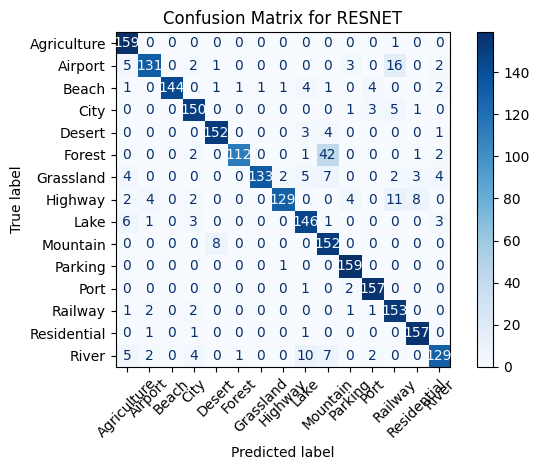

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [35:12<00:00, 262kB/s] 
  7%|▋         | 1/15 [00:56<13:05, 56.07s/it]

Epoch 1: Train Loss 2.1697, Accuracy 0.2666


 13%|█▎        | 2/15 [01:53<12:16, 56.63s/it]

Epoch 2: Train Loss 1.6985, Accuracy 0.4276


 20%|██        | 3/15 [02:49<11:21, 56.75s/it]

Epoch 3: Train Loss 1.5550, Accuracy 0.4732


 27%|██▋       | 4/15 [03:44<10:15, 55.93s/it]

Epoch 4: Train Loss 1.5222, Accuracy 0.4901


 33%|███▎      | 5/15 [04:39<09:16, 55.63s/it]

Epoch 5: Train Loss 1.4207, Accuracy 0.5248


 40%|████      | 6/15 [05:36<08:24, 56.03s/it]

Epoch 6: Train Loss 1.3905, Accuracy 0.5284


 47%|████▋     | 7/15 [06:34<07:32, 56.51s/it]

Epoch 7: Train Loss 1.3335, Accuracy 0.5440


 53%|█████▎    | 8/15 [07:31<06:37, 56.72s/it]

Epoch 8: Train Loss 1.3091, Accuracy 0.5601


 60%|██████    | 9/15 [08:28<05:40, 56.82s/it]

Epoch 9: Train Loss 1.3237, Accuracy 0.5597


 67%|██████▋   | 10/15 [09:25<04:44, 56.80s/it]

Epoch 10: Train Loss 1.2781, Accuracy 0.5701


 73%|███████▎  | 11/15 [10:21<03:47, 56.84s/it]

Epoch 11: Train Loss 1.6086, Accuracy 0.5114


 80%|████████  | 12/15 [11:19<02:50, 56.96s/it]

Epoch 12: Train Loss 1.3176, Accuracy 0.5580


 87%|████████▋ | 13/15 [12:16<01:53, 56.95s/it]

Epoch 13: Train Loss 1.2616, Accuracy 0.5754


 93%|█████████▎| 14/15 [13:12<00:56, 56.80s/it]

Epoch 14: Train Loss 1.2534, Accuracy 0.5793


100%|██████████| 15/15 [14:09<00:00, 56.66s/it]

Epoch 15: Train Loss 1.2069, Accuracy 0.6014


===== VGG Evaluation Metrics =====

              precision    recall  f1-score   support

 Agriculture     0.6923    0.3937    0.5020       160
     Airport     0.3717    0.4437    0.4046       160
       Beach     0.7706    0.5250    0.6245       160
        City     0.4250    0.5312    0.4722       160
      Desert     0.8466    0.8625    0.8545       160
      Forest     0.8768    0.7562    0.8121       160
   Grassland     0.8425    0.7688    0.8039       160
     Highway     0.2826    0.1625    0.2063       160
        Lake     0.8369    0.7375    0.7841       160
    Mountain     0.6355    0.4250    0.5094       160
     Parking     0.7358    0.8875    0.8045       160
        Port     0.5992    0.9625    0.7386       160
     Railway     0.3598    0.5938    0.4481       160
 Residential     0.6222    0.5250    0.5695       160
       River     0.4393    0.4750    0.4565       160

    accuracy                         0.6033      2400
   macro avg     0.6225    0.6033    0.5994 

<Figure size 1200x1000 with 0 Axes>

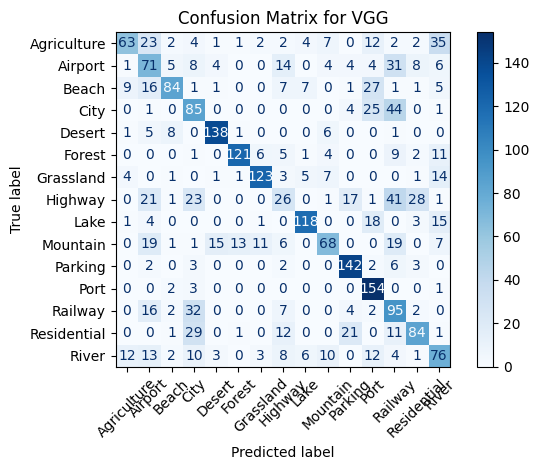

In [11]:
# 同时比较 ResNet 和 VGG
print("🔍 正在比较 ResNet18 与 VGG16 的分类性能...\n")
run_and_evaluate("resnet", classes)
run_and_evaluate("vgg", classes)
